In [1]:
!git clone https://github.com/jiny2001/dcscn-super-resolution.git

Cloning into 'dcscn-super-resolution'...
remote: Enumerating objects: 1227, done.
remote: Total 1227 (delta 0), reused 0 (delta 0), pack-reused 1227
Receiving objects: 100% (1227/1227), 388.63 MiB | 14.15 MiB/s, done.
Resolving deltas: 100% (501/501), done.
Checking out files: 100% (476/476), done.


In [2]:
cd dcscn-super-resolution

/content/dcscn-super-resolution


In [3]:
!git clone https://github.com/niazwazir/TestImage.git

Cloning into 'TestImage'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 39 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [0]:
import os
import cv2
import h5py
import numpy
from keras.models import Model
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation
from keras.optimizers import adam
from keras.layers.merge import concatenate, add
from TestImage import prepare_data as pd
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
DATA_PATH = "data/bsd100/" ################################################################################GIVEN THE NAME OF DATA SET
Random_Crop = 40
Patch_size = 48
label_size = 96
scale = 2


In [0]:
def prepare_training_data():
    names = os.listdir(DATA_PATH)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = DATA_PATH + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # produce Random_Crop random coordinate to crop training img
        if(min(shape[0], shape[1]) - label_size < 0):
            continue
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)

        for j in range(Random_Crop):
            hr_patch = hr_img[Points_x[j]: Points_x[j] + label_size, Points_y[j]: Points_y[j] + label_size]
            lr_patch = cv2.resize(hr_patch, (label_size // scale, label_size // scale), cv2.INTER_CUBIC)

            lr_patch = lr_patch.astype(float) // 255.
            hr_patch = hr_patch.astype(float) // 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label


if __name__ == "__main__":
    data, label = prepare_training_data()
    write_hdf5(data, label, "traininingscale2.h5") #######################################GIVE THE NAME OF h5 FILE
    # _, _a = read_training_data("train.h5")
    # _, _a = read_training_data("test.h5")


In [6]:
from keras.models import Model
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation
from keras.optimizers import adam
from keras.layers.merge import concatenate, add
from TestImage import prepare_data as pd
import numpy


def Res_block():
    _input = Input(shape=(None, None, 64))

    conv = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(_input)
    conv = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear')(conv)

    out = add(inputs=[_input, conv])
    out = Activation('relu')(out)

    model = Model(inputs=_input, outputs=out)

    return model


def model_WAZIR():
    _input = Input(shape=(None, None, 1), name='input')

    Feature = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(_input)
    Feature_out = Res_block()(Feature)

    #Upsampling
    Upsampling1 = Conv2D(filters=4, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Feature_out)
    Upsampling2 = Conv2DTranspose(filters=4, kernel_size=(14,14), strides=(2,2),
                                  padding='same', activation='relu')(Upsampling1)

                           
    Upsampling3 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Upsampling2)

    

    # Mulyi-scale Reconstruction
    Reslayer1 = Res_block()(Upsampling3)

    Reslayer2 = Res_block()(Reslayer1)

    # ***************//
    Multi_scale1 = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Reslayer2)

    Multi_scale2a = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)

    Multi_scale2b = Conv2D(filters=16, kernel_size=(1, 3), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)
    Multi_scale2b = Conv2D(filters=16, kernel_size=(3, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2b)

    Multi_scale2c = Conv2D(filters=16, kernel_size=(1, 3), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)
    Multi_scale2c = Conv2D(filters=16, kernel_size=(3, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2c)

    Multi_scale2d = Conv2D(filters=16, kernel_size=(1, 7), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)
    Multi_scale2d = Conv2D(filters=16, kernel_size=(7, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2d)

    Multi_scale2e = Conv2D(filters=16, kernel_size=(1,7), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2d)

    Multi_scale2f = Conv2D(filters=16, kernel_size=(7,1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2e)

    Multi_scale2g = Conv2D(filters=16, kernel_size=(1,9), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2f)

    Multi_scale2 = concatenate(inputs=[Multi_scale2a, Multi_scale2b, Multi_scale2c, Multi_scale2d,Multi_scale2e, Multi_scale2f, Multi_scale2g])

    out = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Multi_scale2)
    model = Model(input=_input, output=out)

    return model


def WAZIR_train():
    WAZIR = model_WAZIR()
    WAZIR.compile(optimizer=adam(lr=0.0003), loss='mse',metrics=['accuracy'])
    #WAZIR.summary()
    data, label = pd.read_training_data("traininingscale2.h5")#########################################
    WAZIR.fit(data, label, batch_size=128, epochs=20) ##############################################
    WAZIR.save_weights("WAZIR_MODEL_SCALE_2.h5")


def WAZIR_predict():
    WAZIR = model_WAZIR()
    WAZIR.load_weights("WAZIR_MODEL_SCALE_2.h5") ######################################################
    IMG_NAME = "data/set5/img_001.png"
    INPUT_NAME = "INPUT_LOW_RESOLUTION_IMAGE.png"
    OUTPUT_NAME = "MODEL_OUTPUT_IMAGE.png"

    import cv2
    img = cv2.imread(IMG_NAME)
    shape = img.shape
    img = cv2.resize(img, (shape[1] // 2, shape[0] // 2), cv2.INTER_CUBIC) #################################
    cv2.imwrite(INPUT_NAME, img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1))
    Y[0, :, :, 0] = img[:, :, 0]
    img = cv2.resize(img, (shape[1], shape[0]), cv2.INTER_CUBIC)

    pre = WAZIR.predict(Y, batch_size=1)
    pre[pre[:] > 255] = 255
    pre = pre.astype(numpy.uint8)
    img[:, :, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)
    im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)
    im2 = cv2.resize(im2, (img.shape[1], img.shape[0]))
    im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)

    print ("Bicubic:")
    print (cv2.PSNR(im1, im2))
    print ("WAZIR_MODEL:")
    print (cv2.PSNR(im1, im3))


if __name__ == "__main__":
    WAZIR_train()
    WAZIR_predict()


Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`





Epoch 1/20





4000/4000 [==============================] - 44s 11ms/step - loss: 0.0045 - acc: 0.9943
Epoch 2/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0019 - acc: 0.9975
Epoch 3/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0017 - acc: 0.9978
Epoch 4/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0015 - acc: 0.9980
Epoch 5/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0014 - acc: 0.9981
Epoch 6/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0017 - acc: 0.9977
Epoch 7/20
4000/4000 [==============================] - 33s 8ms/step - loss: 0.0021 - acc: 0.9974
Epoch 8/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0014 - acc: 0.9982
Epoch 9/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0014 - acc: 0.9983
Epoch 10/20
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0013 - acc: 0.9983
Epoch 11/2

In [0]:
from PIL import Image
GT_IMAGE = Image.open("data/set5/img_001.png")
LR_IMAGE = Image.open("./INPUT_LOW_RESOLUTION_IMAGE.png")
MODEL_IMAGE = Image.open("./MODEL_OUTPUT_IMAGE.png")

(-0.5, 511.5, 511.5, -0.5)

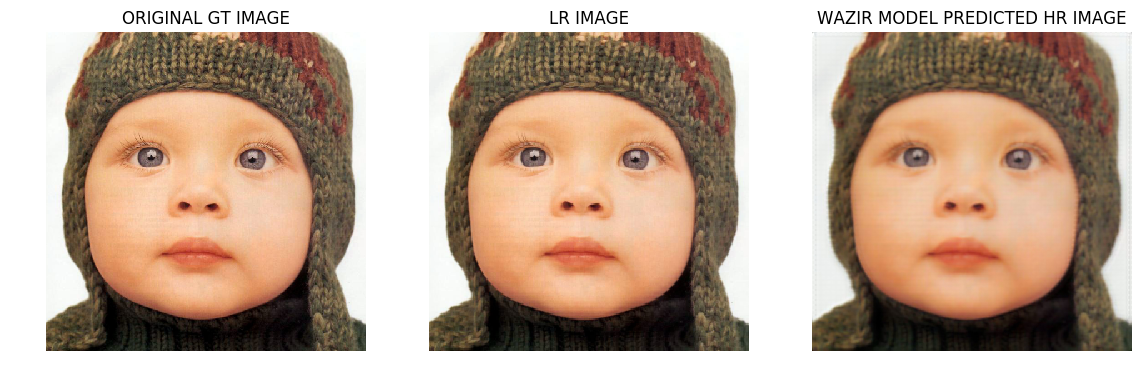

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(14,14),dpi=100)
ax = plt.subplot("131")
ax.imshow(GT_IMAGE)
ax.set_title('ORIGINAL GT IMAGE')
plt.axis('off')

ax = plt.subplot("132")
ax.imshow(LR_IMAGE)
ax.set_title('LR IMAGE')
plt.axis('off')

ax = plt.subplot("133")
ax.imshow(MODEL_IMAGE)
ax.set_title('WAZIR MODEL PREDICTED HR IMAGE')
plt.axis('off')